# Project Description
You work at a startup that sells food products. You need to investigate user behavior for the company's app.
First study the sales funnel. Find out how users reach the purchase stage. How many users actually make it to this stage? How many get stuck at previous stages? Which stages in particular?
Then look at the results of an A/A/B test. (Read on for more information about A/A/B testing.) The designers would like to change the fonts for the entire app, but the managers are afraid the users might find the new design intimidating. They decide to make a decision based on the results of an A/A/B test.
The users are split into three groups: two control groups get the old fonts and one test group gets the new ones. Find out which set of fonts produces better results.
Creating two A groups has certain advantages. We can make it a principle that we will only be confident in the accuracy of our testing when the two control groups are similar. If there are significant differences between the A groups, this can help us uncover factors that may be distorting the results. Comparing control groups also tells us how much time and data we'll need when running further tests.
You'll be using the same dataset for general analytics and for A/A/B analysis. In real projects, experiments are constantly being conducted. Analysts study the quality of an app using general data, without paying attention to whether users are participating in experiments.


# Step 1. Open the data file and read the general information
---
# Step 2. Prepare the data for analysis
---



first import liabraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from scipy import stats
import datetime
from datetime import datetime

import logs file using read_csv

In [2]:
# path = '/datasets/logs_exp_us.csv' # Yandex platform
path = '/content/logs_exp_us.csv' # local
logs = pd.read_csv(path,sep='\t',
                   dtype={'EventName':'category','ExpId':'category'}
                   )

In [3]:
# first look
logs.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   EventName       244126 non-null  category
 1   DeviceIDHash    244126 non-null  int64   
 2   EventTimestamp  244126 non-null  int64   
 3   ExpId           244126 non-null  category
dtypes: category(2), int64(2)
memory usage: 4.2 MB


•	Next I will define new columns names and convert dates into datetime dtype 

•	Add seperate columns with dates

In [5]:
# cols rename:
logs.columns = ['event_name','device_id','timestamp','experiment_id']

In [6]:
logs.tail(1)

,event_name,device_id,timestamp,experiment_id
244125,OffersScreenAppear,5746969938801999050,1565212517,246


In [7]:
# remove last row
logs = logs.iloc[:-1]

In [8]:
# timestamp into datetime dtype:
logs['timestamp'] = logs['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

Add seperate columns with dates

In [9]:
# Add seperate columns with dates
logs['session_date'] = logs['timestamp'].dt.date.astype('datetime64[ns]')

In [10]:
logs.head(5)

,event_name,device_id,timestamp,experiment_id,session_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [11]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244125 entries, 0 to 244124
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_name     244125 non-null  category      
 1   device_id      244125 non-null  int64         
 2   timestamp      244125 non-null  datetime64[ns]
 3   experiment_id  244125 non-null  category      
 4   session_date   244125 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](2), int64(1)
memory usage: 6.1 MB


•	 Check for missing values

In [12]:
# have a look into the timespan:
min_date = logs['timestamp'].min()
max_date = logs['timestamp'].max()
print("start date:                   {}".format(min_date))
print("end date:                     {}".format(max_date))
print('period time covered by dates: {} days'.format(abs(max_date - min_date).days + 1))

start date:                   2019-07-25 04:43:36
end date:                     2019-08-07 21:14:58
period time covered by dates: 14 days


In [13]:
# when looking into info method we see that are no nan values
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244125 entries, 0 to 244124
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_name     244125 non-null  category      
 1   device_id      244125 non-null  int64         
 2   timestamp      244125 non-null  datetime64[ns]
 3   experiment_id  244125 non-null  category      
 4   session_date   244125 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](2), int64(1)
memory usage: 6.1 MB


In [14]:
# a look into exp_id col:
logs['experiment_id'].value_counts() # looks ok

248    85747
246    80303
247    78075
Name: experiment_id, dtype: int64

In [15]:
# into event col:
logs['event_name'].value_counts() # looks fine here as well

MainScreenAppear           119205
OffersScreenAppear          46824
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64

In [16]:
# a look into device columns:
logs['device_id'].value_counts()

6304868067479728361    2308
197027893265565660     2003
4623191541214045580    1771
6932517045703054087    1448
1754140665440434215    1222
                       ... 
7724520246123323531       1
2760145394827990211       1
2086627244641656064       1
8164821368561674670       1
1083512226259476085       1
Name: device_id, Length: 7551, dtype: int64

In [17]:
# no zeros here as well
logs['device_id'].min()

6888746892508752

In [18]:
# final additional look:
logs.isnull().values.any()

False

No missing values found or no relevant zeros instaed

<span style="color:blue">duplicates and conclusions:</span>

In [19]:
print('number of total duplicates rows deleted: {}'.format(len(logs) - len(logs.drop_duplicates())))

number of total duplicates rows deleted: 413


In [20]:
# remove dupps:
logs.drop_duplicates(inplace=True)

In [21]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243712 entries, 0 to 244124
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event_name     243712 non-null  category      
 1   device_id      243712 non-null  int64         
 2   timestamp      243712 non-null  datetime64[ns]
 3   experiment_id  243712 non-null  category      
 4   session_date   243712 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](2), int64(1)
memory usage: 7.9 MB


In [22]:
logs['timestamp'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  243712
unique                 176653
top       2019-08-04 16:23:19
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:14:58
Name: timestamp, dtype: object

In [23]:
logs['device_id'].nunique()

7551

conclusions:
- total number of unique logs is 243713 by 7551 unique users
- first log was on July 25th and the last on Aug 7th
- dtypes: category(2), datetime64\[ns\](2), int64(1)

# Step 3. Study and check the data
---

•	How many events are in the logs?


In [24]:
# types and number of events:
print(print('Types of events           events\n\n{}'.format(logs['event_name'].value_counts()))) # for each type
total_events = logs['event_name'].count()
print('\n\nTotal number of events: {}'.format(total_events))

Types of events           events

MainScreenAppear           119101
OffersScreenAppear          46807
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64
None


Total number of events: 243712


•	How many users are in the logs?


In [25]:
users_in_logs = logs['device_id'].nunique()
print('Number of unique users: {}'.format(users_in_logs))

Number of unique users: 7551


•	What's the average number of events per user?


In [26]:
total_events / users_in_logs

32.275460203946494

<mark> •	What period of time does the data cover? </mark>

<mark>Find the maximum and the minimum date. </mark>

Plot a histogram by date and time. 

Can you be sure that you have equally complete data for the entire period? 

Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. 

Find the moment at which the data starts to be complete and ignore the earlier section. 

What period does the data actually represent?


<mark>done already before</mark>

Plot a histogram by date and time. 


In [27]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

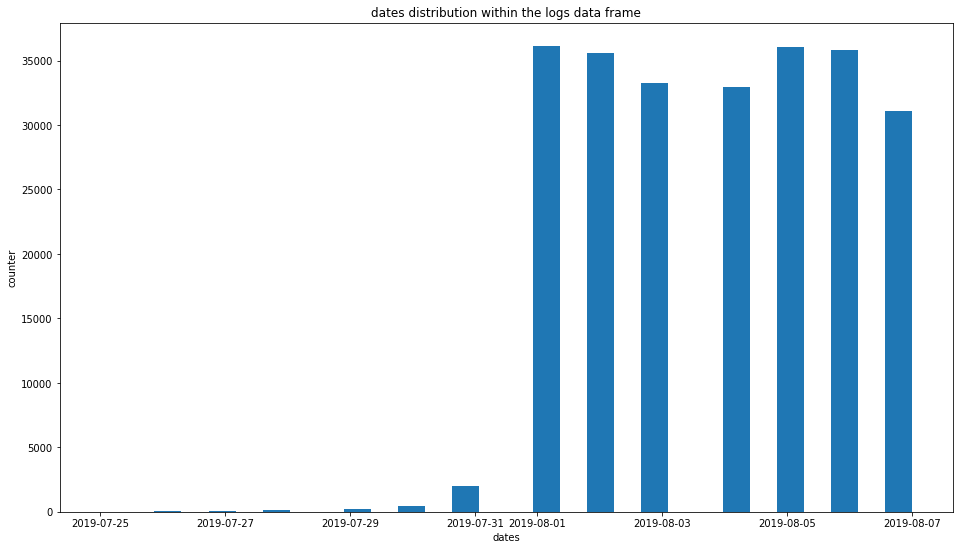

In [28]:
# logs['session_date'].hist()
plt.figure(figsize=(16,9),facecolor='white')
plt.hist(x=logs['session_date'],bins=30)
plt.title('dates distribution within the logs data frame')
plt.xlabel('dates')
plt.ylabel('counter')
plt.show()

- date logs actually starts from Aug 1st. and not as was shown before looking into hist of dates columns
- possible reason of a small number of events in logs before August 1.?
    - there might be a number of reasons for that
once of the assumptions can be because the official release of the app/test was on Aug 1st where the earlier logs were testers or beta version users. However, it also can be due to marketing campany or something like this.


users (device_id) before Aug 1st:

In [29]:
# totla number of logs:
before_aug = logs[logs['session_date'] < '08-01-2019']['device_id'].reset_index() # logs before Aug 1st
after_aug = logs[logs['session_date'] >= '08-01-2019']['device_id'].reset_index() # logs after Aug 1st

In [30]:
# total unique users before Aug 1st:
before_aug['device_id'].nunique()

1451

In [31]:
# total unique users after Aug 1st:
after_aug['device_id'].nunique()

7534

In [32]:
# all unique users before Aug 1st:
before_aug = before_aug.drop('index',axis=1).drop_duplicates()
after_aug = after_aug.drop('index',axis=1).drop_duplicates()

In [33]:
# looking at both tables and output only id that in both before and after tables
before_aug.merge(after_aug,on='device_id',how='inner').count()

device_id    1434
dtype: int64

- 1434 users logs before Aug. 1st are also appears in the logs that after that date
- means that only 17 users are unique in before Aug 1st data
- after this being confirmed we may delete the logs until the 1st of Aug knowing that only 17 unique users logs are dropped 

rows to be dropped:

In [34]:
# logs['device_id'].count() / 
# total number of rows to be dropped:
logs[logs['session_date'] < '08-01-2019']['device_id'].count()

2826

In [35]:
# in percentages:
percent_logs_dropped = logs[logs['session_date'] < '08-01-2019']['device_id'].count() / logs['device_id'].count() *100

In [36]:
print('Total percent of dropped logs is: {:.2f}%'.format(percent_logs_dropped))

Total percent of dropped logs is: 1.16%


In [37]:
# save the original logs just in case to new variable
original_logs = logs

next: drop logs before Aug. 1st

In [38]:
logs = logs[logs['session_date'] >= '08-01-2019']

In [39]:
# make sure all 3 experimental groups in logs data:
logs['experiment_id'].value_counts()

248    84563
246    79301
247    77022
Name: experiment_id, dtype: int64

New time periods for the logs data frame are:

In [40]:
new_max_date = logs['session_date'].max()
new_min_date = logs['session_date'].min()

In [41]:
print("current start date:                   {}".format(new_min_date))
print("current end date:                     {}".format(new_max_date))
print('current period time covered by dates: {} days'.format(abs(new_max_date - new_min_date).days +1))

current start date:                   2019-08-01 00:00:00
current end date:                     2019-08-07 00:00:00
current period time covered by dates: 7 days


**summary for this section**:
- discovered that the actual time span for the logs data frame is 7 days and not 13 days as was shown at the beginning
- original data logs was from mid July till mid Aug but after cheking the histogram of the dates a new picture showed
- discovered that logs till Aug 1st was not a good logs with no good distribution
- total logs deleted  is 2828
- total unique device_id deleted after filtering is 17 users

# Step 4. Study the event funnel
---

•	See what events are in the logs and their frequency of occurrence. Sort them by frequency.


In [42]:
logs['event_name'].value_counts(normalize=True) * 100

MainScreenAppear           48.706857
OffersScreenAppear         19.233995
CartScreenAppear           17.561419
PaymentScreenSuccessful    14.080519
Tutorial                    0.417210
Name: event_name, dtype: float64

- almost half is the 'MainScreenAppear' event shown in the logs
- Tutorial is with almost 0.5% frequency occurrence

•	Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.


In [43]:
device_number = logs.groupby('event_name')['device_id'].nunique().reset_index().rename(columns={'device_id':'users_counter'})
device_number

,event_name,users_counter
0,CartScreenAppear,3734
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [44]:
device_number['proportions'] = device_number['users_counter'] / device_number['users_counter'].sum() * 100

In [45]:
# users counter and proportions also sorted in ascending order by users counter
device_number.sort_values(by='users_counter',ascending=False)

,event_name,users_counter,proportions
1,MainScreenAppear,7419,36.864596
2,OffersScreenAppear,4593,22.822360
0,CartScreenAppear,3734,18.554037
3,PaymentScreenSuccessful,3539,17.585093
4,Tutorial,840,4.173913


- number on unique users main screen is about 37%
- payments screen is 17.5% unique users which about half of the unique users in the main screen
- tutorial is 4% between the unique users

•	In what order do you think the actions took place. Are all of them part of a single sequence? You don't need to take them into account when calculating the funnel.


__ANSWER:__<br>
The sequence of a single event is:<br>
Main Screen > Cart Screen > Payment Successful<br>
Tutorial and is not obligatory in the proccess from the enterance point till the payment made<br>
`*Main Screen*` - the user enter the app<br>
`*Cart Screen*` - user confirms order <br>
`*Payment Successful*` - settled order<br><br>
`*Offers Screen*` - user click on the offers screen before to find other products<br>
`*Tutorial*` - Optional part and not obligatory in the purchase<br><br>
*Alternative sequence can be with Offers screen in it:<br>
Main Screen > Offers Screen >Cart Screen > Payment Successful


•	Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)


*We will take the A>B>C event calculations*

In [46]:
# first lets save with the correct order as a default:
device_number = device_number.sort_values(by='users_counter',ascending=False)

In [47]:
# now remove the rows that are not in our event and save to a new frame:
device_number_event = device_number.reset_index().drop('index',axis=1).drop([1,4]).reset_index().drop('index',axis=1)

In [48]:
# lets add sequence for each event:
device_number_event['sequence'] = ['A','B','C']
device_number_event

,event_name,users_counter,proportions,sequence
0,MainScreenAppear,7419,36.864596,A
1,CartScreenAppear,3734,18.554037,B
2,PaymentScreenSuccessful,3539,17.585093,C


In [49]:
# calculation of ratio sequce using the shift method to a new columns:
device_number_event['ratio_sequence'] = \
(device_number_event['users_counter'] / device_number_event['users_counter'].shift(1)).fillna(1).apply('{:.2%}'.format)

In [50]:
device_number_event

,event_name,users_counter,proportions,sequence,ratio_sequence
0,MainScreenAppear,7419,36.864596,A,100.00%
1,CartScreenAppear,3734,18.554037,B,50.33%
2,PaymentScreenSuccessful,3539,17.585093,C,94.78%


•	At what stage do you lose the most users?


__ANSWER:__<br>
At stage between A > B <br>
half of the users to not get to the Cart screen from their Main Screen<br>
although a pritty good rate noted fron B to C with high percent success means that once the user is in the Cart screen section he will probably make the order

•	What share of users make the entire journey from their first event to payment?


In [51]:
a_to_c = (device_number_event['users_counter'] / device_number_event['users_counter'].shift(2)).dropna().apply('{:.2%}'.format)

In [52]:
print('share of users make the entire sequence from A to C is: {}'.format(a_to_c.iloc[0]))

share of users make the entire sequence from A to C is: 47.70%


<span style="color:blue">conclusions:
- Users reach the cart stage (stage before settlement) has great conversion going to the last occasion and make the payment with  almost 95% of successs
- only half of the users going from their main screen to the cart section when this is stage is critical and we lose a lot users in our funnel proccess. following that our total conversion reate depriciated to below 50% (from A [first] to C [last])
- We may increase the conversion service by making the payment with no cart method and using a flash payment or another methodology to prevent from users drop from B to C
- to improve percentages from A to B we maybe can add an additional step to make an engagment between users or offer them an additional product within step A to increase engagements successes
</span>

# Step 5. Study the results of the experiment
---

*Before start lets check if the same device appears in more than one experiment group*

In [53]:
# create pivot with counter for each group and device_id 
dupp_check = pd.pivot_table(logs,values='timestamp',index='device_id',columns='experiment_id',aggfunc='count')

In [54]:
# test if a device is more than in one experiment group:
print(dupp_check.drop(['246'],axis=1).dropna())
print(dupp_check.drop(['247'],axis=1).dropna())
print(dupp_check.drop(['248'],axis=1).dropna())
print(dupp_check.dropna())

Empty DataFrame
Columns: [247, 248]
Index: []
Empty DataFrame
Columns: [246, 248]
Index: []
Empty DataFrame
Columns: [246, 247]
Index: []
Empty DataFrame
Columns: [246, 247, 248]
Index: []


no dupps found in any case so we now discard the possability of a device id in more than one group and can proceed

•	How many users are there in each group?

In [55]:
table_exp = logs.groupby('experiment_id')['device_id'].nunique().reset_index().rename(columns={'device_id':'users'})
table_exp

,experiment_id,users
0,246,2484
1,247,2513
2,248,2537


*number of unique users for each group is shown in table above*

In [56]:
table_exp['percent'] = (table_exp['users'] / table_exp['users'].sum()).apply('{:.2%}'.format)
table_exp

,experiment_id,users,percent
0,246,2484,32.97%
1,247,2513,33.36%
2,248,2537,33.67%



•	We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.<br>
•	Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?



In [57]:
# lets define the group separately - reminder: experiment_id columns defined as a category in my case:
test_246 = logs[logs['experiment_id'] == '246']['device_id'].unique()
test_247 = logs[logs['experiment_id'] == '247']['device_id'].unique()
control = logs[logs['experiment_id'] == '248']['device_id'].unique()

In [58]:
len(np.concatenate((test_246,test_247)))

4997

In [59]:
event_exp = logs.pivot_table(index='event_name', values='device_id', columns='experiment_id', aggfunc=lambda x: x.nunique())
event_exp

experiment_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


In [60]:
# handle CategoricalIndex issue:
event_exp.columns = pd.Index(list(event_exp.columns))

In [61]:
# now reset_index:
event_exp.reset_index(inplace=True)

In [62]:
event_exp

,event_name,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


- most popular event - MainScreenAppear
- for each group found the number of unique users

check whether there is a statistical difference in conversion aka proportion - "Is the share of users (from all users in the test) that had "MainScreenAppear" of one test group is statistically different from another?"

*now  we use the test of proportions - z-score on the "MainScreenAppear" event*<br>
*create a function to repeat the same test for all the events*

In [63]:
def hypo_check(group1,group2, event, alpha=0.05):
    # let's start with successes, using 
    successes1=event_exp[event_exp['event_name']==event][group1].iloc[0]
    successes2=event_exp[event_exp['event_name']==event][group2].iloc[0]
    
    # for trials we can go back to  logs
    trials1=logs[logs['experiment_id']==group1]['device_id'].nunique()
    trials2=logs[logs['experiment_id']==group2]['device_id'].nunique()
    
    # proportion for success in the first group
    p1 = successes1/trials1

    # proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    # z score:
    z_score = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_score))) * 2

    
    print('H0: μ0 = μ1 \ mean of event', event ,'logs in group',group1,'is equal to mean of group',group2)

    print('H1: μ0 ≠ μ1 \ mean of event', event ,'logs in group',group1,'is not equal to mean of group',group2)
    print('p-value: ', p_value)

    if (p_value < alpha):
        print('Reject H0 hypothesis')
        print('Reject H0 hypothesis means that we can reject the possibility of means between these groups are not different in the ',event,' event.\n\n')
    else:
        print('Can\'t reject H0 hypothesis')
        print('Can\'t reject H0 hypothesis means that we can\'t reject the possibility of  means between these groups are different in the ',event,' event.\n\n')


In [64]:
# hypothesis check. p-value is 5% as defined in the hypo_check func:
hypo_check('246','247','MainScreenAppear')

H0: μ0 = μ1 \ mean of event MainScreenAppear logs in group 246 is equal to mean of group 247
H1: μ0 ≠ μ1 \ mean of event MainScreenAppear logs in group 246 is not equal to mean of group 247
p-value:  0.7570597232046099
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of  means between these groups are different in the  MainScreenAppear  event.




In [65]:
# iterate for all the events:
for i in event_exp['event_name']:
  hypo_check('246','247',i)

H0: μ0 = μ1 \ mean of event CartScreenAppear logs in group 246 is equal to mean of group 247
H1: μ0 ≠ μ1 \ mean of event CartScreenAppear logs in group 246 is not equal to mean of group 247
p-value:  0.22883372237997213
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of  means between these groups are different in the  CartScreenAppear  event.


H0: μ0 = μ1 \ mean of event MainScreenAppear logs in group 246 is equal to mean of group 247
H1: μ0 ≠ μ1 \ mean of event MainScreenAppear logs in group 246 is not equal to mean of group 247
p-value:  0.7570597232046099
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of  means between these groups are different in the  MainScreenAppear  event.


H0: μ0 = μ1 \ mean of event OffersScreenAppear logs in group 246 is equal to mean of group 247
H1: μ0 ≠ μ1 \ mean of event OffersScreenAppear logs in group 246 is not equal to mean of group 247
p-value:  0.2

- Failed to reject between groups 246 & 247 in every event seperatley 
- groups are statistically differs in A/A test means groups distributed differently

•	Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?


*compare 247 & 248*

In [66]:
for i in event_exp['event_name']:
  hypo_check('247','248',i)

H0: μ0 = μ1 \ mean of event CartScreenAppear logs in group 247 is equal to mean of group 248
H1: μ0 ≠ μ1 \ mean of event CartScreenAppear logs in group 247 is not equal to mean of group 248
p-value:  0.5786197879539783
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of  means between these groups are different in the  CartScreenAppear  event.


H0: μ0 = μ1 \ mean of event MainScreenAppear logs in group 247 is equal to mean of group 248
H1: μ0 ≠ μ1 \ mean of event MainScreenAppear logs in group 247 is not equal to mean of group 248
p-value:  0.4587053616621515
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of  means between these groups are different in the  MainScreenAppear  event.


H0: μ0 = μ1 \ mean of event OffersScreenAppear logs in group 247 is equal to mean of group 248
H1: μ0 ≠ μ1 \ mean of event OffersScreenAppear logs in group 247 is not equal to mean of group 248
p-value:  0.91

- Failed to reject h0 in every event in groups 247 and 248
- When reject null hypothesis mean that that using our z score the groups are <span style="color:blue">not different</span>


<span style="color:blue">Sorry about that and I would like to clarify myself here. <br>
when H0 can't be rejected that it means that we accept null hypothesis of μ0 = μ1 so groups of course are NOT differ each other<br>
please take my sencere appologie for this confussion (late our work) and take it as a general note to all that mentioned<br>
adjusments were done</span>

*compare 246 & 248*

In [67]:
for i in event_exp['event_name']:
  hypo_check('246','248',i)

H0: μ0 = μ1 \ mean of event CartScreenAppear logs in group 246 is equal to mean of group 248
H1: μ0 ≠ μ1 \ mean of event CartScreenAppear logs in group 246 is not equal to mean of group 248
p-value:  0.07842923237520116
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of  means between these groups are different in the  CartScreenAppear  event.


H0: μ0 = μ1 \ mean of event MainScreenAppear logs in group 246 is equal to mean of group 248
H1: μ0 ≠ μ1 \ mean of event MainScreenAppear logs in group 246 is not equal to mean of group 248
p-value:  0.2949721933554552
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of  means between these groups are different in the  MainScreenAppear  event.


H0: μ0 = μ1 \ mean of event OffersScreenAppear logs in group 246 is equal to mean of group 248
H1: μ0 ≠ μ1 \ mean of event OffersScreenAppear logs in group 246 is not equal to mean of group 248
p-value:  0.2

- Failed to reject h0 in every event in groups 246 and 248
- When reject null hypothesis mean that that using our z score the groups are  not the same

*compare 246+247 & 248*

In [68]:
# to maketo combine both 246+247  I will create new columns with only 2 groups: 
logs['experiment_id_']= logs['experiment_id'].apply(lambda x: '248' if x=='248' else '246+247')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [69]:
event_exp_ = logs.pivot_table(index='event_name', values='device_id', columns='experiment_id_', aggfunc=lambda x: x.nunique())
event_exp_

experiment_id_,246+247,248
event_name,,
CartScreenAppear,2504,1230
MainScreenAppear,4926,2493
OffersScreenAppear,3062,1531
PaymentScreenSuccessful,2358,1181
Tutorial,561,279


In [70]:
# handle CategoricalIndex issue:
event_exp_.columns = pd.Index(list(event_exp_.columns))

In [71]:
# now reset_index:
event_exp_.reset_index(inplace=True)

In [72]:
event_exp_

,event_name,246+247,248
0,CartScreenAppear,2504,1230
1,MainScreenAppear,4926,2493
2,OffersScreenAppear,3062,1531
3,PaymentScreenSuccessful,2358,1181
4,Tutorial,561,279


In [73]:
# define another def check:
def hypo_check_a_b(group1,group2, event, alpha=0.05):
    # let's start with successes, using 
    successes1=event_exp_[event_exp_['event_name']==event][group1].iloc[0]
    successes2=event_exp_[event_exp_['event_name']==event][group2].iloc[0]
    
    # for trials we can go back to  logs
    trials1=logs[logs['experiment_id_']==group1]['device_id'].nunique()
    trials2=logs[logs['experiment_id_']==group2]['device_id'].nunique()
    
    
    p1 = successes1/trials1 # proportion for success in the first group
    p2 = successes2/trials2 # proportion for success in the second group
    p_combined = (successes1 + successes2) / (trials1 + trials2) # proportion in a combined dataset
    difference = p1 - p2
    z_score = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) # z score
    distr = stats.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_score))) * 2
        
    print('H0: μ0 = μ1 \ mean of event', event ,'logs in group',group1,'is equal to mean of group',group2)

    print('H1: μ0 ≠ μ1 \ mean of event', event ,'logs in group',group1,'is not equal to mean of group',group2)
    print('p-value: ', p_value)
        
    if (p_value < alpha):
        print('Reject H0 hypothesis')
        print('Reject H0 hypothesis means that we can reject the possibility of means between these groups are not different in the ',event,' event.\n\n')

    else:
        print('Can\'t reject H0 hypothesis')
        print('Can\'t reject H0 hypothesis means that we can\'t reject the possibility of means between these groups are different in the ',event,' event.\n\n')

In [74]:
for i in event_exp_['event_name']:
  hypo_check_a_b('246+247','248',i)

H0: μ0 = μ1 \ mean of event CartScreenAppear logs in group 246+247 is equal to mean of group 248
H1: μ0 ≠ μ1 \ mean of event CartScreenAppear logs in group 246+247 is not equal to mean of group 248
p-value:  0.18175875284404386
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of means between these groups are different in the  CartScreenAppear  event.


H0: μ0 = μ1 \ mean of event MainScreenAppear logs in group 246+247 is equal to mean of group 248
H1: μ0 ≠ μ1 \ mean of event MainScreenAppear logs in group 246+247 is not equal to mean of group 248
p-value:  0.29424526837179577
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of means between these groups are different in the  MainScreenAppear  event.


H0: μ0 = μ1 \ mean of event OffersScreenAppear logs in group 246+247 is equal to mean of group 248
H1: μ0 ≠ μ1 \ mean of event OffersScreenAppear logs in group 246+247 is not equal to mean of 

- Failed to reject null hypothesis in each event with with the groups
- the meaning is that the test groups combined are <span style="color:blue">not</span> different from control group as well

•	What significance level have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you carried out. With a statistical significance level of 0.1, one in 10 results could be false. What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.


__Answer:__<br>
The significanec level in our tests was used with a=5% whereas the number of total tests ran (excluding last part when combining the tests group) was 15 tests at total wihch is lead us to a multiple comparison issue<br>
When using a big number of test on the data we may receive an type one error of false positive mean that we reject the nul hyopthesis by error<br>
The probability of making at least one mistake in the course of k comparisons will be:<br>
1-(1-a)^k<br> 
*k - number of testes<br>
in our private case the possibility of this error to happen is:<br>
1-(1-0.05)^15 = 53%<br><br><br>
The Bonferroni procedure (the Bonferroni correction):
Common correction of the required significance level in this cases used with Bonferroni correction, whereas,  the significance level ɑ is divided by the number of hypotheses which in our case wil lead us to a significance level of a=0.3% which a extremely low level of significance

Maybe this link will be interesting for you: https://www.analyticsvidhya.com/blog/2019/09/everything-know-about-p-value-from-scratch-data-science/

In our case of the project if we change the alpha using Bonferroni correction the results won't change and remain the same

# <span style="color:blue">General Conclusion:</span>
in preproccessing point we acknowledged that the the actual datetime of the users logs was from the start of Aug 1st whereas the  test probably started<br>
- our main goal was to check the A/A/B tests included in the data to have our statistical significance for each test to point if the differences between test group 246 & 247 are <span style="color:blue">not</span> differ from the control 248 group in a seperate way or combined
- after running more than 15 test we got the assumptions that in our cinclusions of reject H0 we may incounter for another dilema which is type 1 error (false positive) which may lead us to some other significant misleading results
- using a Bonferroni correction won't provide us with a solution since getting our alpha even smaller than was tested won't change the initial results. another important thing to rememmber is when using Bonferroni correction we increase error type 2 which we didn't had in mind before but  it is important to know that adjustments like this not always be helpful or significally change our results and avoid error in general. so it may not always be a good solution
- when reffering to the tests we had with our Pvalue of 5% we didn't succeeded to reject H0 in any of the events using the z score test which mean that H<span style="color:blue">0</span> is the hypothesis applies where the means are <span style="color:blue">not</span>  different between the events with test group to control group